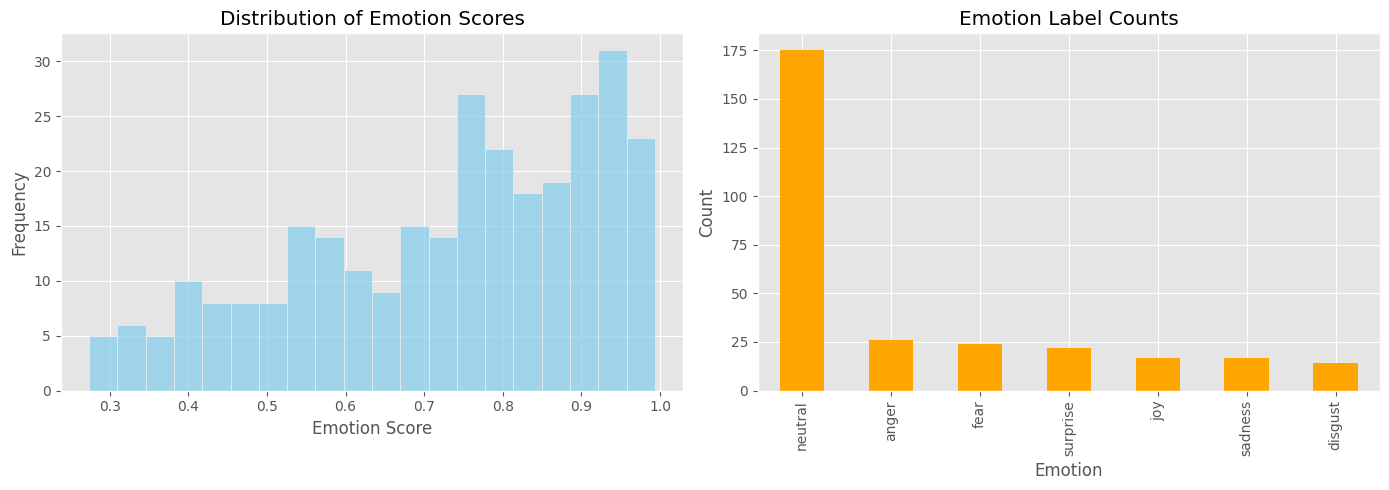

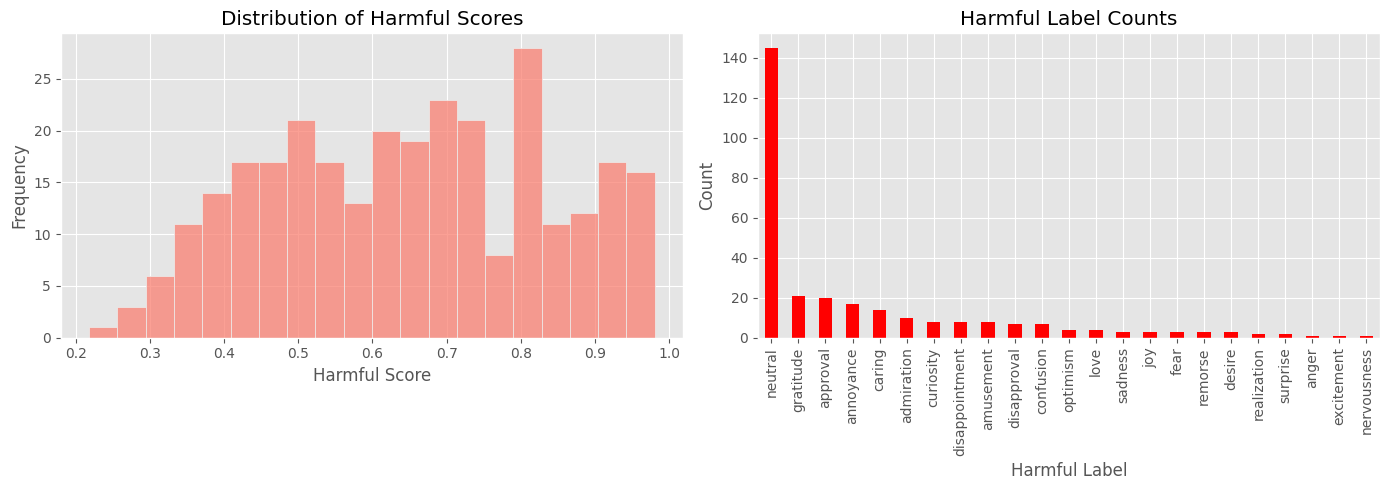

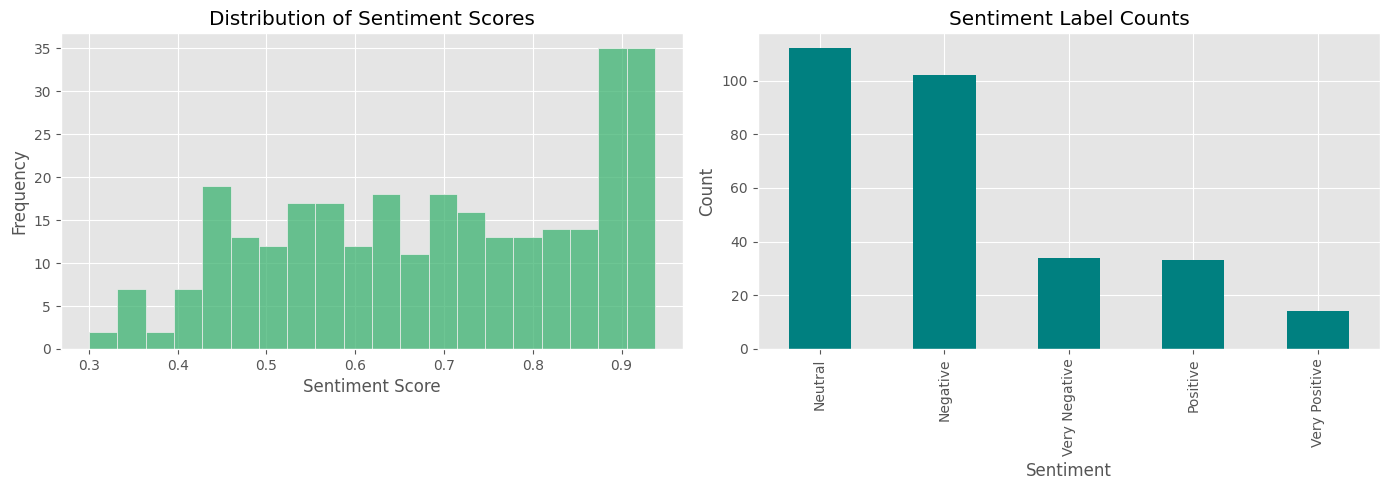

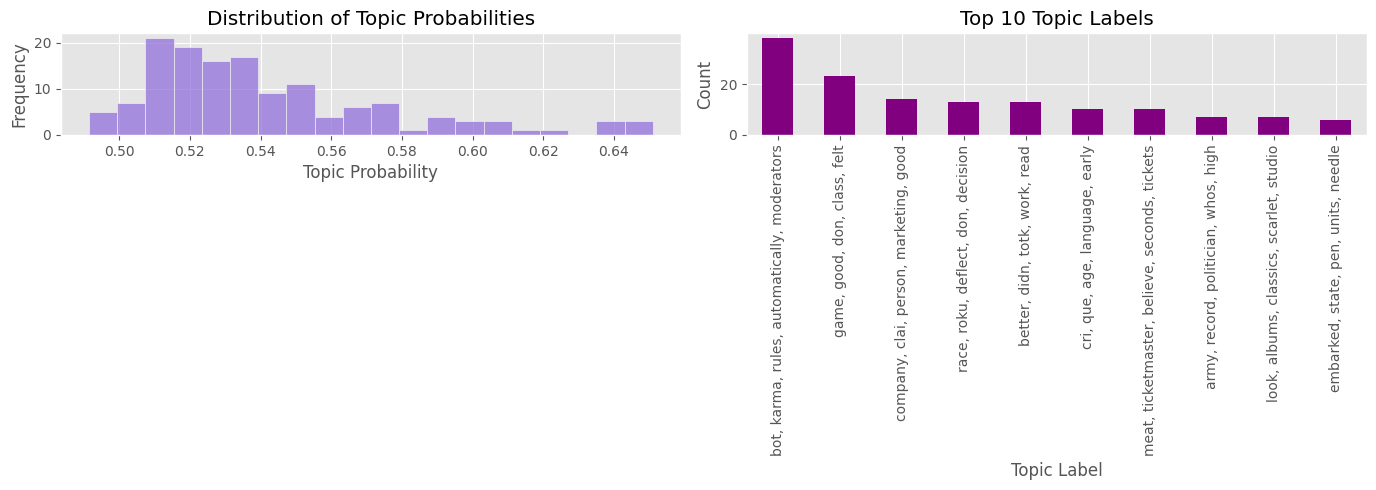

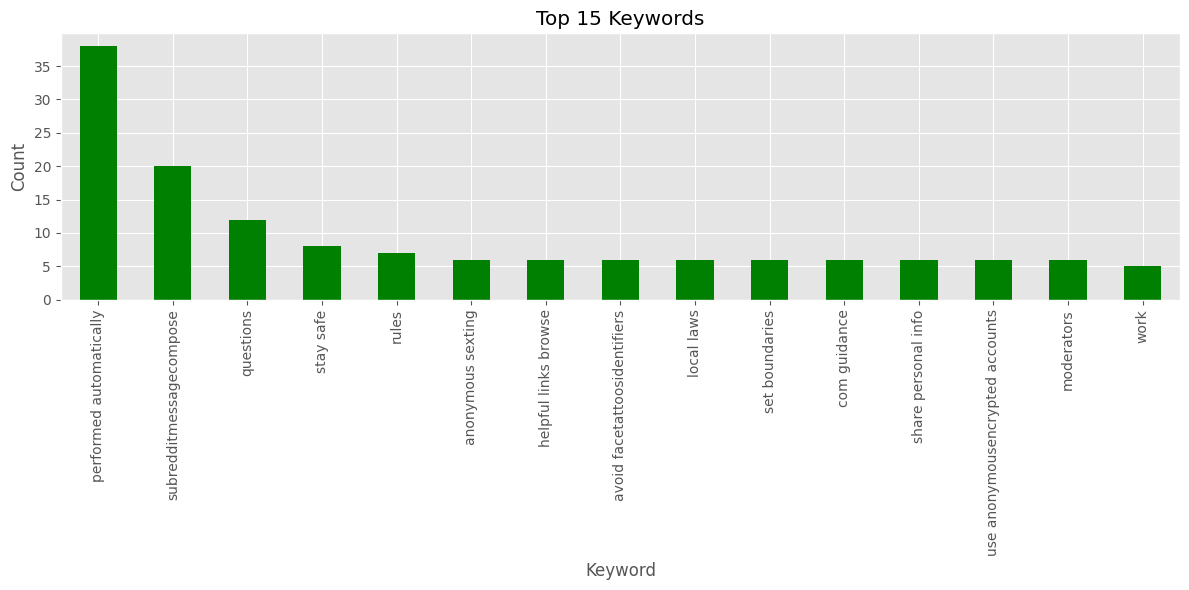

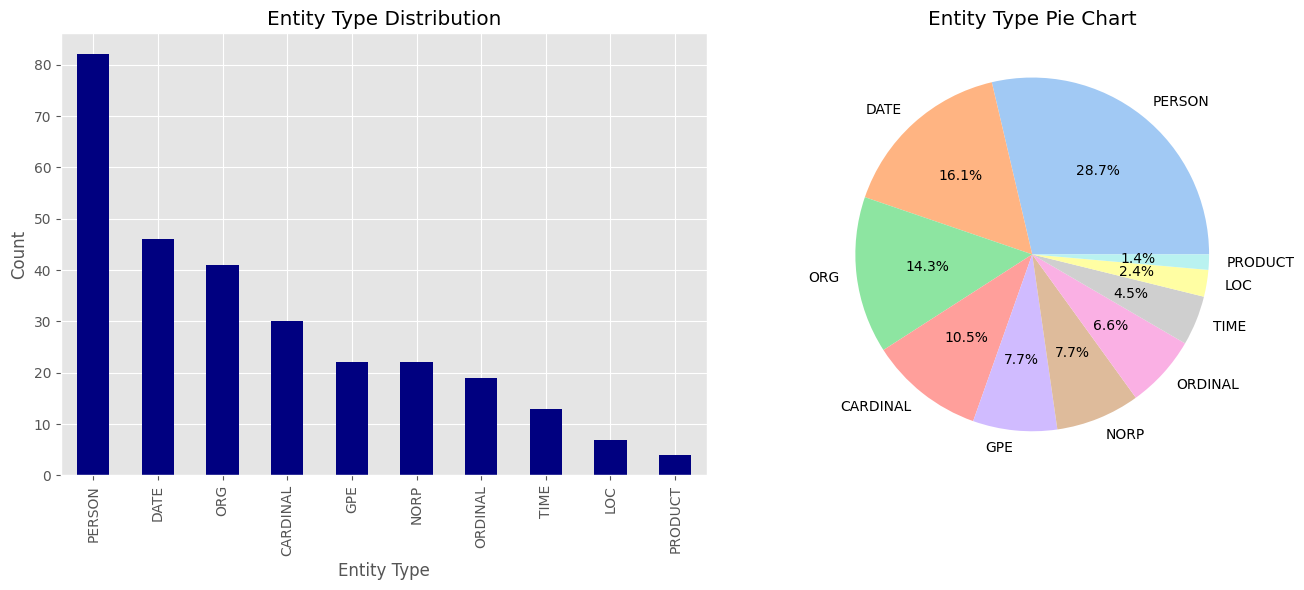

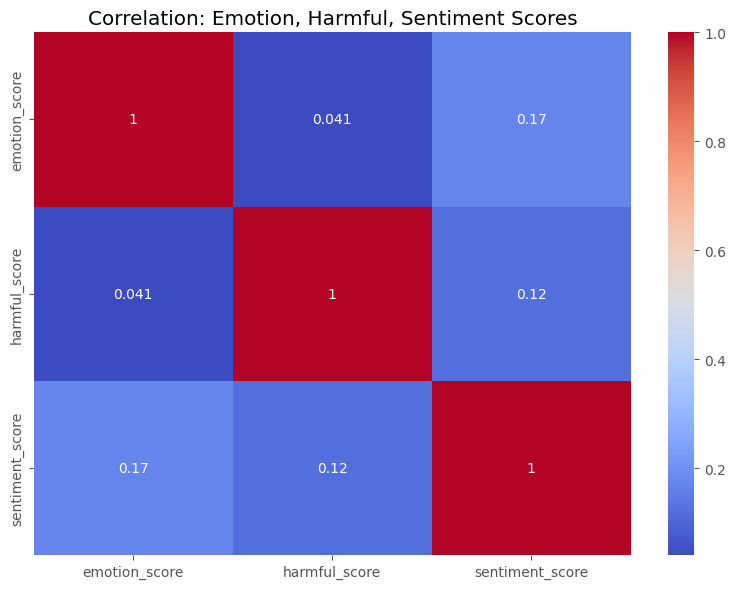

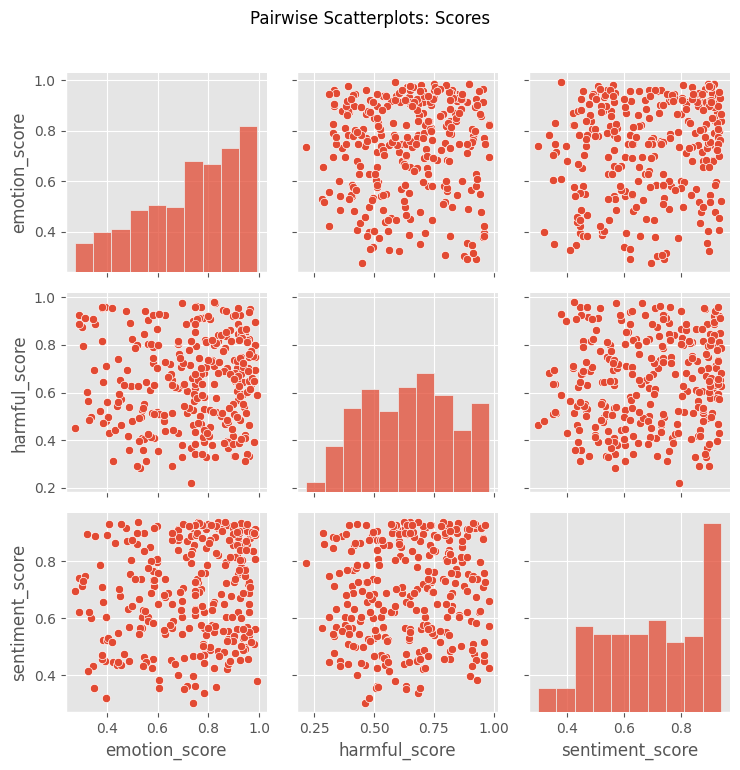

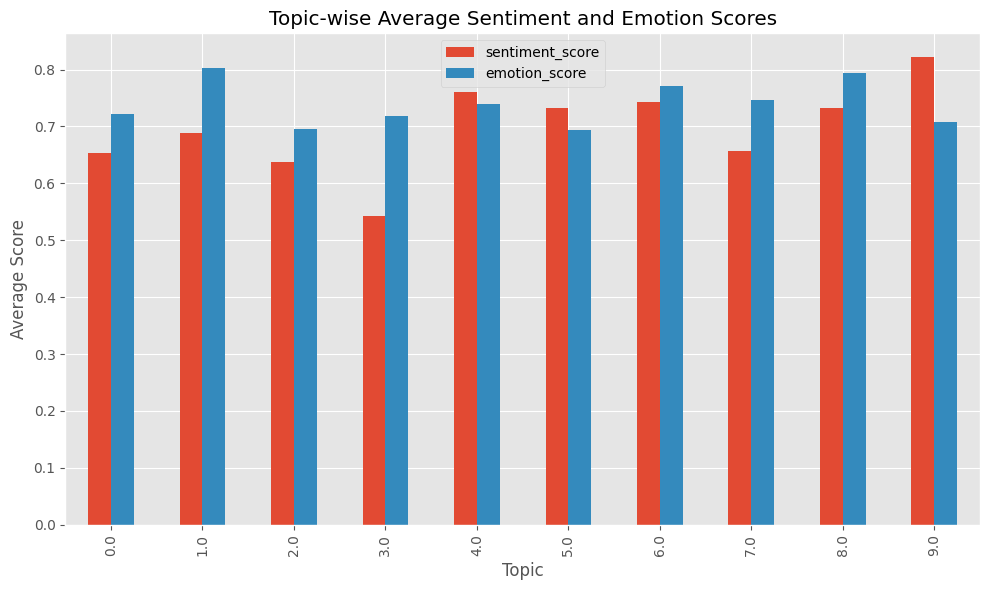

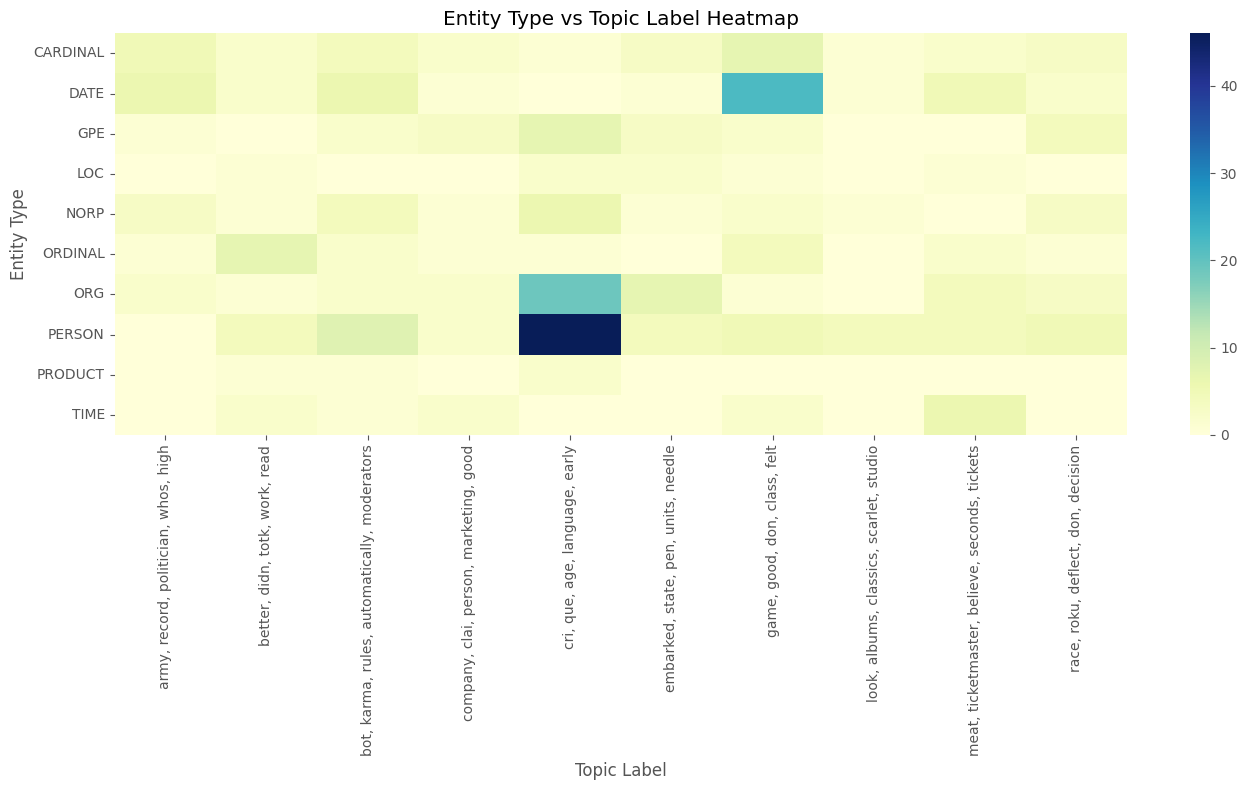

C:\Users\Adarsh Ranjan\AppData\Local\Temp\ipykernel_7792\3702316433.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


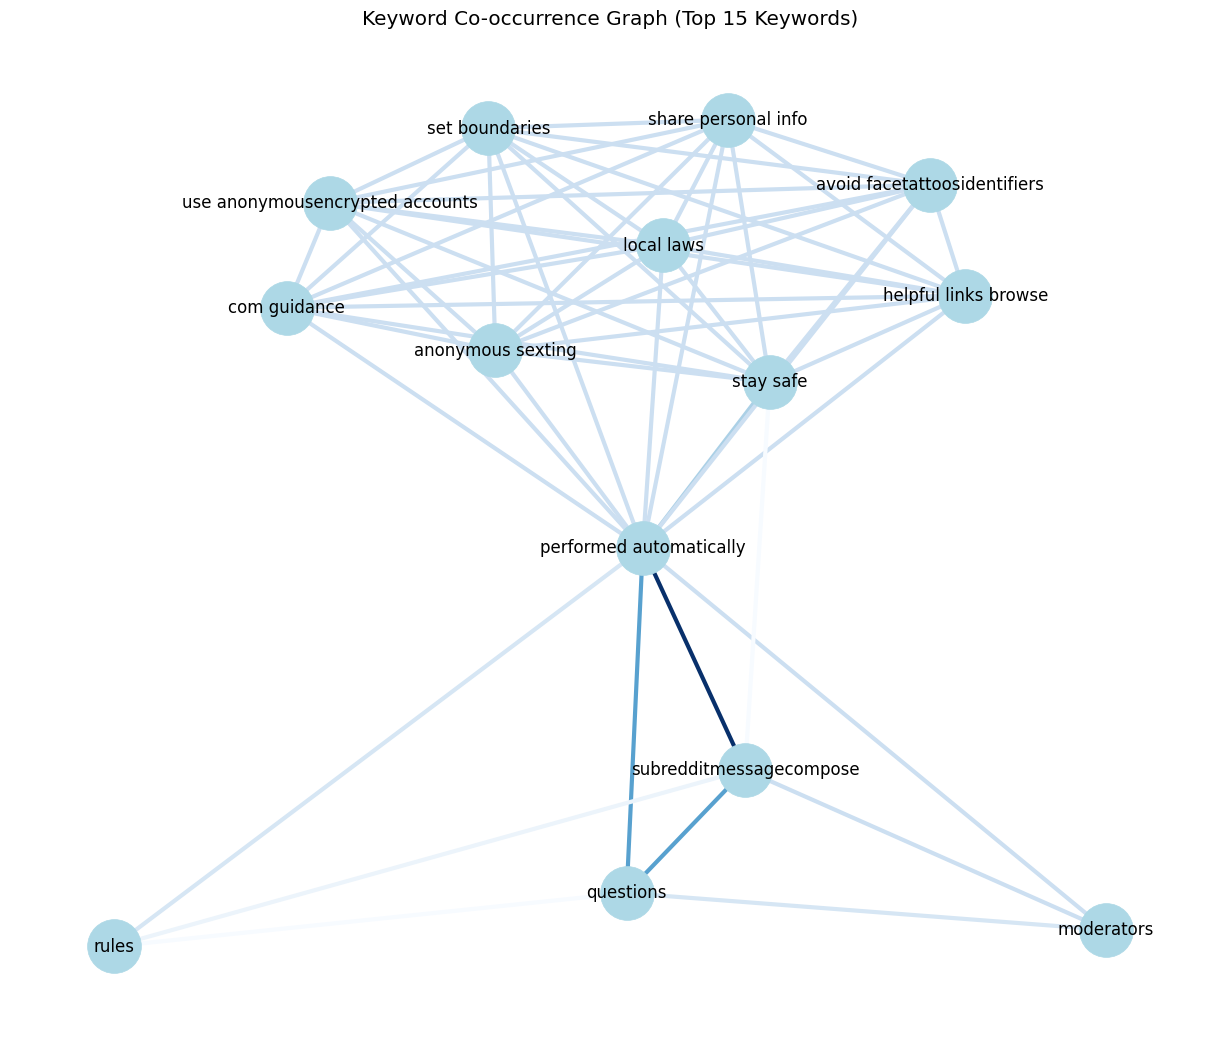

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
import networkx as nx

# Load CSVs (update filenames as needed)
emotion_df = pd.read_csv(r'E:\Coding\BDA-PySpark\realtime-pipeline\results\emotion_results.csv')
entities_df = pd.read_csv(r'E:\Coding\BDA-PySpark\realtime-pipeline\results\entities.csv')
harmful_df = pd.read_csv(r'E:\Coding\BDA-PySpark\realtime-pipeline\results\harmful_flags.csv')
keywords_df = pd.read_csv(r'E:\Coding\BDA-PySpark\realtime-pipeline\results\keywords.csv')
sentiment_df = pd.read_csv(r'E:\Coding\BDA-PySpark\realtime-pipeline\results\sentiment_results.csv')
topic_df = pd.read_csv(r'E:\Coding\BDA-PySpark\realtime-pipeline\results\topic_results.csv')

plt.style.use('ggplot')

# 1. Emotion: Distribution & Label Counts (side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(emotion_df['score'], bins=20, color='skyblue', ax=axes[0])
axes[0].set(title='Distribution of Emotion Scores', xlabel='Emotion Score', ylabel='Frequency')
emotion_df['emotion'].value_counts().plot(kind='bar', color='orange', ax=axes[1])
axes[1].set(title='Emotion Label Counts', xlabel='Emotion', ylabel='Count')
plt.tight_layout()
plt.show()

# 2. Harmful: Distribution & Label Counts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(harmful_df['score'], bins=20, color='salmon', ax=axes[0])
axes[0].set(title='Distribution of Harmful Scores', xlabel='Harmful Score', ylabel='Frequency')
harmful_df['harmful_label'].value_counts().plot(kind='bar', color='red', ax=axes[1])
axes[1].set(title='Harmful Label Counts', xlabel='Harmful Label', ylabel='Count')
plt.tight_layout()
plt.show()

# 3. Sentiment: Distribution & Label Counts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(sentiment_df['score'], bins=20, color='mediumseagreen', ax=axes[0])
axes[0].set(title='Distribution of Sentiment Scores', xlabel='Sentiment Score', ylabel='Frequency')
sentiment_df['sentiment'].value_counts().plot(kind='bar', color='teal', ax=axes[1])
axes[1].set(title='Sentiment Label Counts', xlabel='Sentiment', ylabel='Count')
plt.tight_layout()
plt.show()

# 4. Topic: Probability Distribution & Top Labels
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
if 'topic_prob' in topic_df.columns:
    sns.histplot(topic_df['topic_prob'], bins=20, color='mediumpurple', ax=axes[0])
    axes[0].set(title='Distribution of Topic Probabilities', xlabel='Topic Probability', ylabel='Frequency')
else:
    axes[0].text(0.5, 0.5, 'No topic_prob column found', ha='center', va='center')
topic_df['topic_label'].value_counts().head(10).plot(kind='bar', color='purple', ax=axes[1])
axes[1].set(title='Top 10 Topic Labels', xlabel='Topic Label', ylabel='Count')
plt.tight_layout()
plt.show()

# 5. Keyword Frequency (single large plot)
all_keywords = []
for kw_list in keywords_df['keywords'].dropna():
    all_keywords += [kw.strip() for kw in kw_list.split(",") if kw.strip()]
kw_counts = pd.Series(all_keywords).value_counts()
plt.figure(figsize=(12, 6))
kw_counts.head(15).plot(kind='bar', color='green')
plt.title('Top 15 Keywords')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 6. Entity Type Distribution: Bar + Pie side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
entity_types = []
for ent_str in entities_df['entities'].dropna():
    entity_types += re.findall(r':(\w+)', ent_str)
et_counts = pd.Series(entity_types).value_counts()
et_counts.plot(kind='bar', color='navy', ax=axes[0])
axes[0].set(title='Entity Type Distribution', xlabel='Entity Type', ylabel='Count')
et_counts.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'), ylabel='', ax=axes[1])
axes[1].set(title='Entity Type Pie Chart')
plt.tight_layout()
plt.show()

# 7. Correlation Heatmap: Emotion, Harmful, Sentiment Scores
joined = emotion_df[['score']].rename(columns={'score': 'emotion_score'})
joined['harmful_score'] = harmful_df['score']
joined['sentiment_score'] = sentiment_df['score']
plt.figure(figsize=(8, 6))
sns.heatmap(joined.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation: Emotion, Harmful, Sentiment Scores')
plt.tight_layout()
plt.show()

# 8. Pairplot of Scores (single figure)
sns.pairplot(joined)
plt.suptitle('Pairwise Scatterplots: Scores', y=1.02)
plt.tight_layout()
plt.show()

# 9. Topic Segmentation: Average Sentiment/Emotion by Topic (bar plot)
segmented = pd.concat([
    topic_df[['topic']],
    sentiment_df[['score']].rename(columns={'score': 'sentiment_score'}),
    emotion_df[['score']].rename(columns={'score': 'emotion_score'})
], axis=1)
avg_scores = segmented.groupby('topic').mean()
avg_scores[['sentiment_score', 'emotion_score']].plot(kind='bar', figsize=(10, 6))
plt.title('Topic-wise Average Sentiment and Emotion Scores')
plt.xlabel('Topic')
plt.ylabel('Average Score')
plt.tight_layout()
plt.show()

# 10. Entity-Topic Mapping Heatmap (single plot)
entity_topic_map = []
for ents, topic in zip(entities_df['entities'].dropna(), topic_df['topic_label']):
    types = re.findall(r':(\w+)', ents)
    entity_topic_map += [(etype, topic) for etype in types]
et_topic_df = pd.DataFrame(entity_topic_map, columns=['EntityType', 'TopicLabel'])
matrix = pd.crosstab(et_topic_df['EntityType'], et_topic_df['TopicLabel'])
plt.figure(figsize=(14, 8))
sns.heatmap(matrix, cmap="YlGnBu")
plt.title('Entity Type vs Topic Label Heatmap')
plt.ylabel("Entity Type")
plt.xlabel("Topic Label")
plt.tight_layout()
plt.show()

# 11. Keyword Co-occurrence Network (single plot)
top_N = 15
top_keywords = kw_counts.head(top_N).index.tolist()
edges = []
for kw_list in keywords_df['keywords'].dropna():
    kws = set([kw.strip() for kw in kw_list.split(",") if kw.strip() and kw.strip() in top_keywords])
    if len(kws) > 1:
        for pair in itertools.combinations(kws, 2):
            edges.append(tuple(sorted(pair)))
edge_df = pd.DataFrame(edges, columns=['kw1', 'kw2'])
edge_weights = edge_df.value_counts().reset_index(name='weight')
G = nx.Graph()
for _, row in edge_weights.iterrows():
    G.add_edge(row['kw1'], row['kw2'], weight=row['weight'])
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.7)
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
nx.draw(G, pos, node_color='lightblue', with_labels=True, node_size=1500,
        edgelist=edges, edge_color=weights, width=3.0, edge_cmap=plt.cm.Blues)
plt.title('Keyword Co-occurrence Graph (Top 15 Keywords)')
plt.tight_layout()
plt.show()
